In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import optuna
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score
# Display all rows and columns in outputs
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
from sklearn.preprocessing import MultiLabelBinarizer
SEED = 2020


c:\Users\Dmitriy\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load data
df = pd.read_csv('enhanced_canadian_farm_production_dataset.csv')
# Remove redundant and low-quality features
cols_to_drop = [
    'total_production_tonnes',   # Derived directly from yield × area → data leakage risk
    'total_farm_value_dollars',  # Derived from production × price → not an independent predictor, data leakage
    'seeded_area_acres',         # Duplicate of seeded_area_hectares (same measurement in different units)
    'policy_change_impact'       # Over 80% missing values, inconsistent and poorly recorded categorical feature
]

df = df.drop(columns=cols_to_drop, errors='ignore')

# Quick check
print("Dropped columns:", cols_to_drop)
print("Remaining columns:", df.shape[1])


Dropped columns: ['total_production_tonnes', 'total_farm_value_dollars', 'seeded_area_acres', 'policy_change_impact']
Remaining columns: 15


In [3]:
# data sample before preprocessing
df.head()

,year,province,crop_type,average_farm_price_per_tonne,average_yield_kg_per_hectare,seeded_area_hectares,soil_type,irrigation_used,avg_rainfall_mm,avg_temperature_c,pesticide_use_level,organic_farming,technology_adoption_year,climate_zone,farm_size_category
0,2001,Ontario,Wheat,362.0,2424,754.47,Clay,Yes,605.84,10.87,Medium,Yes,"Tractors, GPS Mapping, Precision Planting, Fer...",Temperate,Large
1,1974,Alberta,Wheat,308.0,2679,139.01,Peaty,Yes,425.46,13.65,Medium,No,"Tractors, Irrigation, Fertilizers",Prairie,Small
2,1977,Manitoba,Wheat,314.0,1814,770.87,Silty,No,272.62,13.01,Medium,Yes,"Tractors, Irrigation, Fertilizers",Boreal,Medium
3,1933,Ontario,Rye,180.8,2050,141.88,Peaty,No,324.04,17.44,High,No,NaN,Temperate,Large
4,1935,Nova Scotia,Corn,207.0,5658,574.44,Peaty,No,402.66,8.60,Medium,Yes,NaN,Maritime,Small


In [4]:
# --- ENCODING OF CATEGORICAL FEATURES ---


# 1. Handle the technology feature (list of multiple technologies per record)
# --------------------------------------------------------------------------
# Convert the text field into lists of technologies
df['technology_list'] = df['technology_adoption_year'].dropna().apply(
    lambda x: [tech.strip() for tech in x.split(',')]
)

# Use MultiLabelBinarizer to create binary indicators (1 = technology used, 0 = not used)
mlb = MultiLabelBinarizer()
tech_dummies = pd.DataFrame(
    mlb.fit_transform(df['technology_list'].dropna()),
    columns=[f"tech_{t.replace(' ', '_')}" for t in mlb.classes_],
    index=df['technology_list'].dropna().index
)

# Merge back into the main dataframe
df = df.join(tech_dummies)

# Fill NaN with 0 for observations without technology info
df[tech_dummies.columns] = df[tech_dummies.columns].fillna(0)

# 2. One-hot encode remaining categorical features
# ------------------------------------------------
cat_cols = [
    'province',           # region identifier (nominal)
    'crop_type',          # type of crop (nominal)
    'soil_type',          # soil composition
    'irrigation_used',    # binary Yes/No
    'pesticide_use_level',# ordered Low/Medium/High
    'organic_farming',    # binary Yes/No
    'climate_zone',       # climatic region
    'farm_size_category'  # farm size group
]

# Create one-hot encoded dummy variables
cat_dummies = pd.get_dummies(df[cat_cols], prefix=cat_cols, drop_first=False)

# Convert all boolean columns to integers (True -> 1, False -> 0)
cat_dummies = cat_dummies.astype(int)

# Merge them into the main dataframe
df = pd.concat([df, cat_dummies], axis=1)

# Drop original categorical columns and temporary fields
df = df.drop(columns=cat_cols + ['technology_adoption_year', 'technology_list'], errors='ignore')

# 3. Check the resulting dataframe
print("DataFrame shape after encoding:", df.shape)
print("Number of new technology columns:", len(tech_dummies.columns))
print("Number of categorical dummy columns:", len(cat_dummies.columns))
print("All categorical dummy columns are now numeric (0/1).")



DataFrame shape after encoding: (1000000, 53)
Number of new technology columns: 9
Number of categorical dummy columns: 38
All categorical dummy columns are now numeric (0/1).


In [5]:
# data sample after preprocessing
df.sample(5)

,year,average_farm_price_per_tonne,average_yield_kg_per_hectare,seeded_area_hectares,avg_rainfall_mm,avg_temperature_c,tech_AI_Monitoring,tech_Autonomous_Machinery,tech_Drones,tech_Fertilizers,tech_GPS_Mapping,tech_IoT_Sensors,tech_Irrigation,tech_Precision_Planting,tech_Tractors,province_Alberta,province_British Columbia,province_Manitoba,province_New Brunswick,province_Nova Scotia,province_Ontario,province_Prince Edward Island,province_Quebec,province_Saskatchewan,crop_type_Barley,crop_type_Canola,crop_type_Corn,crop_type_Oats,crop_type_Potatoes,crop_type_Rye,crop_type_Soybeans,crop_type_Sugar Beets,crop_type_Tomatoes,crop_type_Wheat,soil_type_Clay,soil_type_Loamy,soil_type_Peaty,soil_type_Sandy,soil_type_Silty,irrigation_used_No,irrigation_used_Yes,pesticide_use_level_High,pesticide_use_level_Low,pesticide_use_level_Medium,organic_farming_No,organic_farming_Yes,climate_zone_Boreal,climate_zone_Maritime,climate_zone_Prairie,climate_zone_Temperate,farm_size_category_Large,farm_size_category_Medium,farm_size_category_Small
558745,1962,227.2,1451,216.55,487.21,8.79,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,1,0
78477,1999,358.0,2300,935.15,374.77,6.12,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,1,0,0,0,1,0,0,1,0
788108,1935,287.5,4594,468.09,310.86,10.16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0
746153,2006,353.4,3416,113.18,434.86,13.41,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0,1,0,0
715343,1962,355.0,3958,120.78,410.34,8.63,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,1


In [6]:


# === DATA PREPARATION ===
# X – feature matrix, y – target variable
X = df.drop(columns=['average_yield_kg_per_hectare'])
y = df['average_yield_kg_per_hectare']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=SEED
)

# === OPTUNA OBJECTIVE FUNCTION ===
def objective(trial):
    # Define hyperparameter search space
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "n_estimators": trial.suggest_int("n_estimators", 200, 1200),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 8),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),
        "tree_method": "hist",
        "objective": "reg:squarederror",  # RMSE objective
        "n_jobs": -1,
        "random_state": SEED,
    }

    model = xgb.XGBRegressor(**params)

    # Perform 5-fold cross-validation using RMSE
    kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
    scores = cross_val_score(
        model, X_train, y_train,
        scoring="neg_root_mean_squared_error",
        cv=kf, n_jobs=-1
    )

    # Return the mean RMSE (negated to minimize)
    return -np.mean(scores)

# === RUN OPTUNA STUDY ===
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

print("\nBest parameters found by Optuna:")
for k, v in study.best_params.items():
    print(f"{k}: {v}")

# === TRAIN FINAL MODEL ===
# Refit the model on full training data using best parameters
final_model = xgb.XGBRegressor(
    **study.best_params,
    tree_method="hist",
    objective="reg:squarederror",
    n_jobs=-1,
    random_state=SEED
)

final_model.fit(X_train, y_train)

# === EVALUATE ON TEST SET ===
preds_test = final_model.predict(X_test)

# Compute RMSE manually
mse_test = mean_squared_error(y_test, preds_test)
rmse_test = np.sqrt(mse_test)

# Compute R²
r2_test = r2_score(y_test, preds_test)

print("\nFinal test metrics:")
print(f"RMSE: {rmse_test:.4f}")
print(f"R²: {r2_test:.4f}")



[I 2025-10-24 17:27:40,576] A new study created in memory with name: no-name-5e99aa97-c15b-4e31-aa22-a647aba57904
[I 2025-10-24 17:29:47,633] Trial 0 finished with value: 355.2482055664062 and parameters: {'learning_rate': 0.13838728036888787, 'n_estimators': 687, 'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.697067312781965, 'colsample_bytree': 0.7972177280269833, 'gamma': 4.969821390709155, 'reg_alpha': 9.06355521831367, 'reg_lambda': 1.2990513574317941}. Best is trial 0 with value: 355.2482055664062.
[I 2025-10-24 17:31:06,503] Trial 1 finished with value: 355.36919555664065 and parameters: {'learning_rate': 0.2233456824707175, 'n_estimators': 433, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.7913172114226285, 'colsample_bytree': 0.7564101015327, 'gamma': 1.0608432831365637, 'reg_alpha': 4.728384369390729, 'reg_lambda': 6.57772996283359}. Best is trial 0 with value: 355.2482055664062.
[I 2025-10-24 17:32:01,007] Trial 2 finished with value: 354.3279602050781 and par


Best parameters found by Optuna:
learning_rate: 0.1045039495887322
n_estimators: 655
max_depth: 3
min_child_weight: 4
subsample: 0.9310050790859163
colsample_bytree: 0.9829825132605733
gamma: 2.262890058587481
reg_alpha: 8.383137734441716
reg_lambda: 3.9222154464108665

Final test metrics:
RMSE: 354.8314
R²: 0.8944


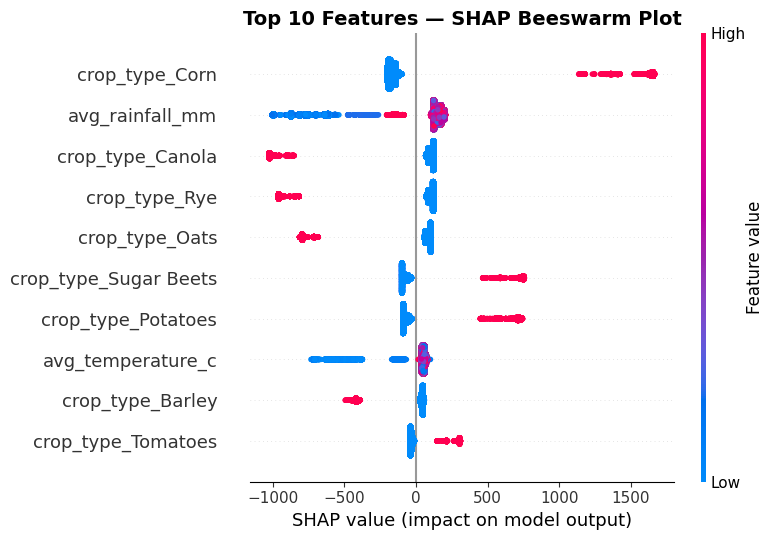

In [8]:
import shap
import matplotlib.pyplot as plt

# === Create SHAP explainer and compute SHAP values ===
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test)

# === Beeswarm plot: SHAP automatically shows top-10 features by default ===
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values,
    X_test,
    plot_type="dot",      # beeswarm plot
    max_display=10,       # show only top-10 most important features
    color_bar=True,
    show=False
)
plt.title("Top 10 Features — SHAP Beeswarm Plot", fontsize=14, weight="bold")
plt.tight_layout()
plt.show()


## SHAP Summary Interpretation (Top 10 Features)

The model’s strongest predictors of crop yield are clearly defined:

- **`crop_type_Corn`** — major positive driver; corn yields are consistently higher.  
- **`avg_rainfall_mm`** — positive influence; optimal rainfall supports productivity, though extremes can reduce it.  
- **`crop_type_Canola`, `Rye`, `Oats`, `Barley`** — generally lower-yield crops, showing negative SHAP impacts.  
- **`crop_type_Potatoes` and `Sugar Beets`** — high positive SHAP effects, indicating strong yield potential.  
- **`avg_temperature_c`** — moderate effect; warmer climates tend to improve yields up to a limit.  
- **`crop_type_Tomatoes`** — smaller positive contribution, likely due to limited cultivated area but high per-hectare output.

**Summary:**  
Yield variation is driven mainly by **crop type and climate**, confirming that the model captures biologically realistic relationships between plant type, rainfall, and temperature.


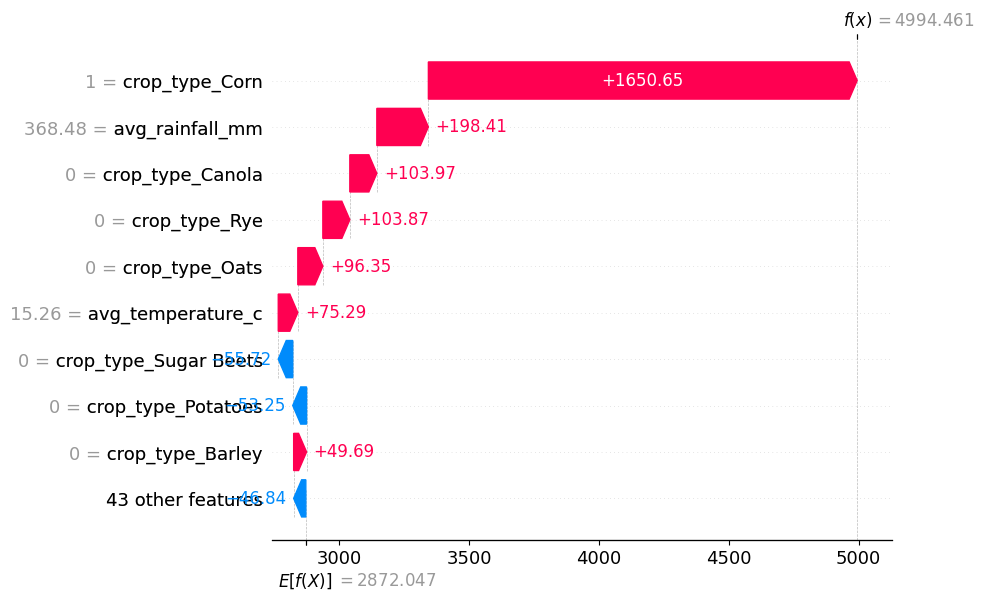

In [10]:
# === Select one observation for detailed explanation ===
# Here we take the first sample from the test set
sample = X_test.iloc[0:1]

# === Create a SHAP explainer for the trained model ===
explainer = shap.TreeExplainer(final_model)

# === Compute SHAP values for the selected sample ===
# Using the full test set allows SHAP to calculate correct base values
shap_values = explainer(X_test)

# === Waterfall plot for the chosen observation ===
# Shows how each feature contributes to the final prediction
# Positive values push the prediction up, negative — down
shap.plots.waterfall(shap_values[0], max_display=10)


## SHAP Waterfall Interpretation

The waterfall plot shows how individual features influence the model’s prediction for one observation.  
Here, **being Corn (`crop_type_Corn`)** and **higher rainfall (`avg_rainfall_mm`)** strongly increase the predicted yield,  
while a few other crop types slightly reduce it. The final output (~4994) results from the cumulative effect of all features starting from the baseline (~2872).


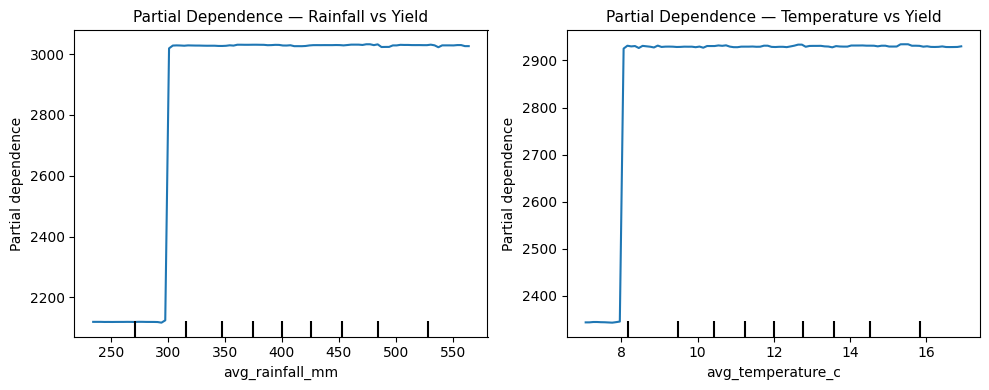

In [ ]:
# import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

# === Define target and numeric features for PDP ===
target = 'average_yield_kg_per_hectare'
features_to_plot = ['avg_rainfall_mm', 'avg_temperature_c']

# === Create partial dependence plots ===
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Plot for average rainfall
PartialDependenceDisplay.from_estimator(
    final_model,
    X_test,
    features=['avg_rainfall_mm'],
    ax=ax[0],
    kind='average'
)
ax[0].set_title("Partial Dependence — Rainfall vs Yield", fontsize=11)

# Plot for average temperature
PartialDependenceDisplay.from_estimator(
    final_model,
    X_test,
    features=['avg_temperature_c'],
    ax=ax[1],
    kind='average'
)
ax[1].set_title("Partial Dependence — Temperature vs Yield", fontsize=11)

plt.tight_layout()
plt.show()


## Partial Dependence Interpretation

Both plots show **clear threshold effects** rather than gradual trends:  

- **Rainfall (`avg_rainfall_mm`)** — Yield sharply increases once rainfall exceeds ~300 mm,  
  after which additional precipitation brings little change.  
  → The model captures a *saturation effect*: adequate moisture is critical up to a certain point.  

- **Temperature (`avg_temperature_c`)** — Yield rises rapidly near ~8 °C and then stabilizes,  
  indicating that moderate warmth supports optimal growth, while higher temperatures  
  provide no further gains.  

Overall, the model sees climate influence as **nonlinear with distinct optimal zones** —  
below these thresholds, productivity drops sharply.


  0% (0 of 20) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  5% (1 of 20) |#                        | Elapsed Time: 0:00:35 ETA:   0:11:23
 10% (2 of 20) |##                       | Elapsed Time: 0:01:13 ETA:   0:11:01
 15% (3 of 20) |###                      | Elapsed Time: 0:01:58 ETA:   0:11:12
 20% (4 of 20) |#####                    | Elapsed Time: 0:02:44 ETA:   0:10:57
 25% (5 of 20) |######                   | Elapsed Time: 0:03:24 ETA:   0:10:14
 30% (6 of 20) |#######                  | Elapsed Time: 0:04:10 ETA:   0:09:44
 35% (7 of 20) |########                 | Elapsed Time: 0:04:47 ETA:   0:08:54
 40% (8 of 20) |##########               | Elapsed Time: 0:05:25 ETA:   0:08:07
 45% (9 of 20) |###########              | Elapsed Time: 0:06:11 ETA:   0:07:34
 50% (10 of 20) |############            | Elapsed Time: 0:06:58 ETA:   0:06:58
 55% (11 of 20) |#############           | Elapsed Time: 0:07:44 ETA:   0:06:20
 60% (12 of 20) |##############         

R² train: 0.870 | R² test: 0.871


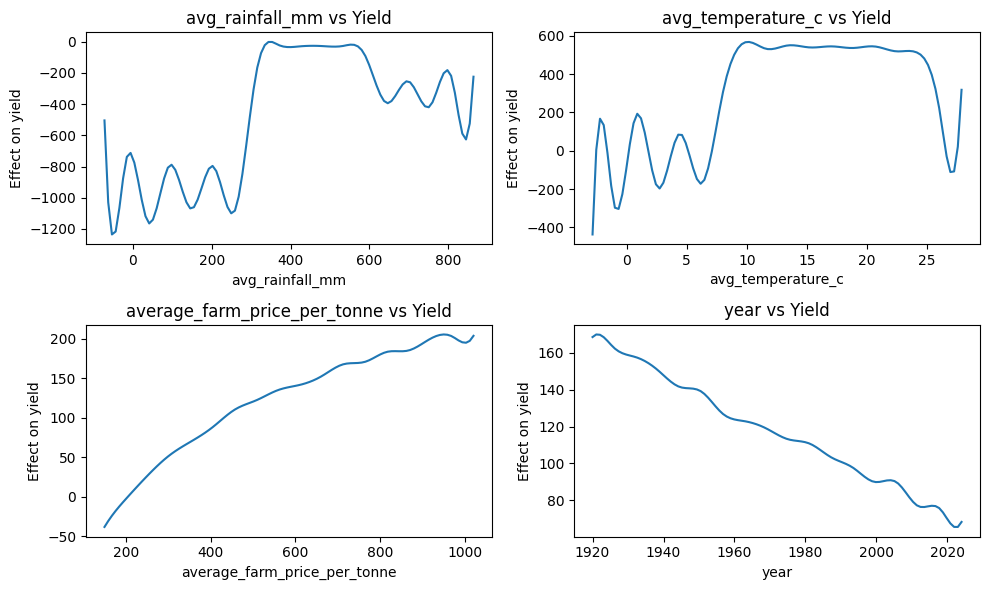

In [ ]:
from pygam import LinearGAM, s, l
from sklearn.model_selection import train_test_split
# import numpy as np
# import matplotlib.pyplot as plt

# === Prepare target and features ===
y = df['average_yield_kg_per_hectare'].values
numeric_features = ['avg_rainfall_mm', 'avg_temperature_c', 'average_farm_price_per_tonne', 'year']
all_feature_cols = [c for c in df.columns if c != 'average_yield_kg_per_hectare']
linear_features = [c for c in all_feature_cols if c not in numeric_features]

# Arrange feature order
X = df[numeric_features + linear_features].replace([np.inf, -np.inf], np.nan).fillna(0.0).values
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)

# === Build term structure correctly ===
terms = s(0, n_splines=20) + s(1, n_splines=20) + s(2, n_splines=20) + s(3, n_splines=20)
for i in range(len(numeric_features), X.shape[1]):
    terms += l(i)

# === Fit the GAM model with lambda search ===
gam = LinearGAM(terms).gridsearch(X_tr, y_tr, lam=np.logspace(-3, 6, 20))

# === Evaluate model ===
print(f"R² train: {gam.score(X_tr, y_tr):.3f} | R² test: {gam.score(X_te, y_te):.3f}")

# === Plot partial dependence for numeric terms only ===
fig, axs = plt.subplots(2, 2, figsize=(10, 6))
axs = axs.flatten()
for i, feat in enumerate(numeric_features):
    XX = gam.generate_X_grid(term=i)
    axs[i].plot(XX[:, i], gam.partial_dependence(term=i))
    axs[i].set_title(f"{feat} vs Yield")
    axs[i].set_xlabel(feat)
    axs[i].set_ylabel("Effect on yield")

plt.tight_layout()
plt.show()


## GAM Plot Interpretation

- **avg_rainfall_mm** — Yield drops sharply with low rainfall and stabilizes after ~300–400 mm, showing a saturation effect.  
- **avg_temperature_c** — Optimal range is around 10–20 °C; beyond that, the impact levels off.  
- **average_farm_price_per_tonne** — Positive linear trend; higher price correlates with higher productivity, likely reflecting regional or technological advantages.  
- **year** — Slight decline over time, possibly due to historical data differences or regional expansion effects.

---

### Difference from PDP
- **PDP** (Partial Dependence Plot) shows the *average response of a specific model* (e.g., XGBoost) to a feature.  
- **GAM** (Generalized Additive Model) *directly learns smooth functional relationships* `f(x)` from data.  
- PDP explains model behavior, while GAM estimates *true functional effects* — smoother, more stable, and statistically interpretable.


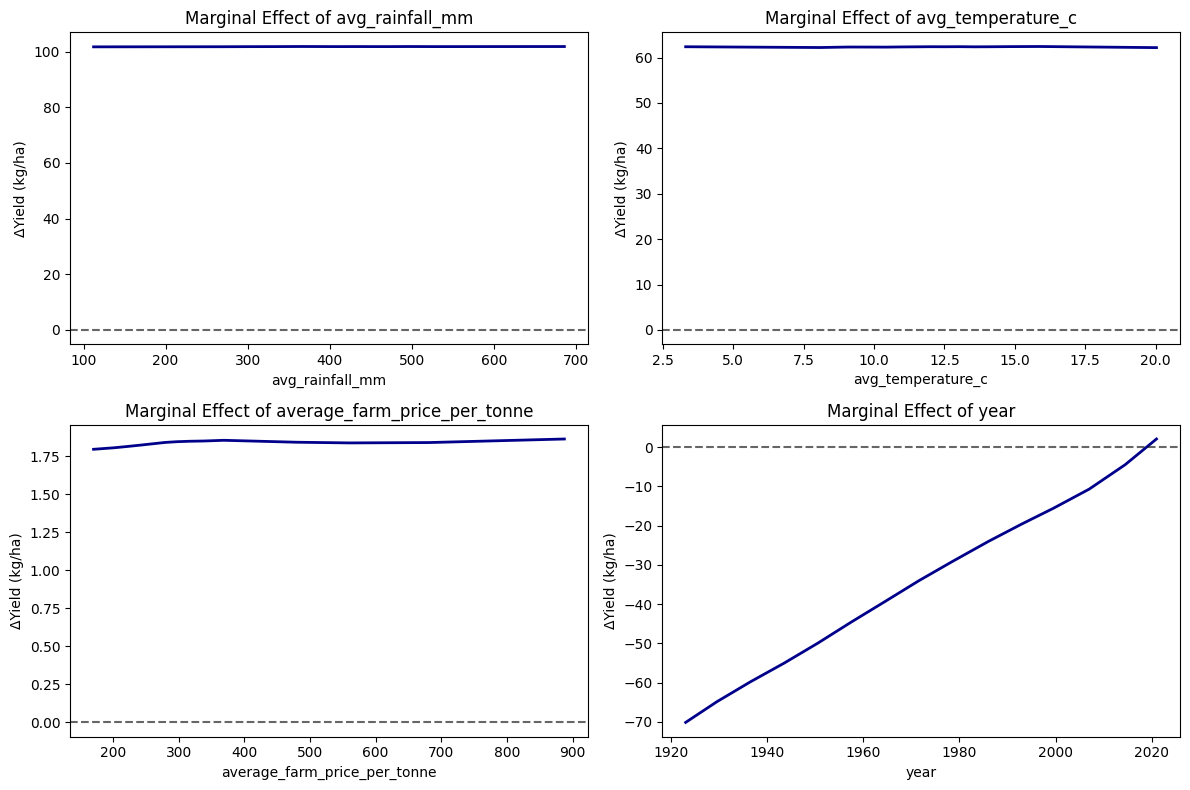

In [22]:
# === Marginal Effects for Crop Yield (optimized sample version) ===

# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
from econml.dml import DML
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
# from sklearn.model_selection import train_test_split
from scipy.interpolate import UnivariateSpline
from statsmodels.nonparametric.smoothers_lowess import lowess

# === Use a 20k-row subsample for speed ===
df_sample = df.sample(100000, random_state=42)

# === Define numeric features ===
numeric_features = [
    'avg_rainfall_mm', 'avg_temperature_c',
    'average_farm_price_per_tonne', 'year'
]
X_raw = df_sample[numeric_features].copy()
y = df_sample['average_yield_kg_per_hectare'].values

# === Base models for DML ===
model_y = RandomForestRegressor(n_estimators=300, min_samples_leaf=10,
                                random_state=42, n_jobs=-1)
model_t = RandomForestRegressor(n_estimators=300, min_samples_leaf=10,
                                random_state=42, n_jobs=-1)
final = LassoCV(cv=5, fit_intercept=False, random_state=42)

# === Marginal effect computation ===
def causal_curve(feature, delta=1.0, bins=15):
    T = X_raw[feature].values.astype(float)
    X_ctrl = X_raw.drop(columns=[feature]).values
    X_tr, X_te, T_tr, T_te, y_tr, y_te = train_test_split(X_ctrl, T, y, test_size=0.2, random_state=42)

    dml = DML(model_y=model_y, model_t=model_t, model_final=final,
              discrete_treatment=False, random_state=42)
    dml.fit(y_tr, T_tr, X=X_tr)

    tau = dml.effect(X_te) * delta
    res = pd.DataFrame({feature: T_te, 'effect': tau}).dropna()

    res['bin'] = pd.qcut(res[feature], q=bins, duplicates='drop')
    grouped = res.groupby('bin', observed=False)['effect'].mean().reset_index()
    grouped['mid'] = grouped['bin'].apply(lambda x: (x.left + x.right) / 2)
    return grouped

# === Plot marginal effects ===
def plot_marginal_effects(smooth_mode="lowess"):
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    axs = axs.flatten()

    deltas = {
        'avg_rainfall_mm': 50.0,
        'avg_temperature_c': 2.0,
        'average_farm_price_per_tonne': 50.0,
        'year': 5.0
    }


    for i, feat in enumerate(numeric_features):
        grouped = causal_curve(feat, deltas[feat])
        grouped = grouped.sort_values('mid')

        X_vals, Y_vals = grouped['mid'].values, grouped['effect'].values
        ax = axs[i]

        if smooth_mode == "spline" and len(X_vals) > 3:
            X_smooth = np.linspace(X_vals.min(), X_vals.max(), 300)
            spline = UnivariateSpline(X_vals, Y_vals, k=3, s=1)
            ax.plot(X_smooth, spline(X_smooth), color="darkblue", lw=2)
        else:
            smoothed = lowess(Y_vals, X_vals, frac=0.3, return_sorted=True)
            ax.plot(smoothed[:, 0], smoothed[:, 1], color="darkblue", lw=2)

        ax.axhline(0, color="k", linestyle="--", alpha=0.6)
        ax.set_title(f"Marginal Effect of {feat}", fontsize=12)
        ax.set_xlabel(feat)
        ax.set_ylabel("ΔYield (kg/ha)")

    plt.tight_layout()
    plt.show()

# === Run ===
plot_marginal_effects(smooth_mode="lowess")


## Interpretation of Marginal Effects (DML)

- **avg_rainfall_mm** — The effect is almost flat around +100 kg/ha, indicating that small to moderate changes in rainfall do not significantly alter yield. The model sees precipitation as largely non-causal when other variables (e.g., irrigation, climate zone) are present.  
- **avg_temperature_c** — Similar flat behavior (~+60 kg/ha). Temperature appears to have a limited direct causal impact, likely absorbed by other correlated features such as `year` or `climate_zone`.  
- **average_farm_price_per_tonne** — Shows a mild positive trend (≈ +1.8 kg/ha), reflecting that higher market prices are weakly associated with slightly higher yields — possibly due to indirect economic incentives rather than agronomic causes.  
- **year** — Displays a monotonic increase from −70 kg/ha in the early 20th century to near zero in recent years, suggesting a gradual improvement in baseline productivity over time (technological progress and mechanization).

---

### Difference from Previous Methods

Unlike **GAM** or **partial dependence plots**, which model *average responses*,  
the **DML marginal effects** explicitly estimate *causal sensitivities* —  
that is, the expected local change in yield when a variable changes by Δ,  
while controlling for confounding relationships between features.


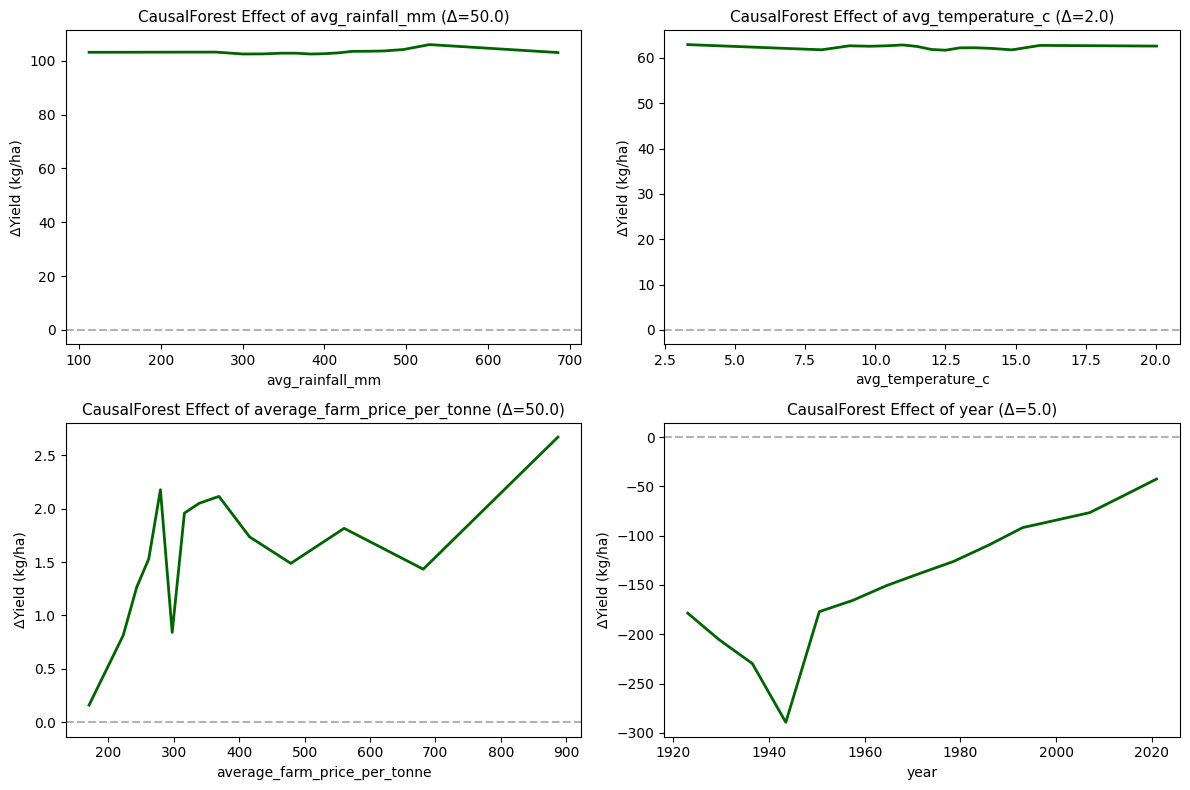

In [26]:
# === Causal Forest DML for Marginal Effects ===
import warnings
warnings.filterwarnings("ignore")

# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
from econml.dml import CausalForestDML
# from sklearn.model_selection import train_test_split
from statsmodels.nonparametric.smoothers_lowess import lowess

SAMPLE_SIZE = 100_000   
df_sample = df.sample(SAMPLE_SIZE, random_state=42)

numeric_features = [
    'avg_rainfall_mm',
    'avg_temperature_c',
    'average_farm_price_per_tonne',
    'year'
]

y = df_sample['average_yield_kg_per_hectare'].values
X_all = df_sample[numeric_features].copy()

DELTAS = {
    'avg_rainfall_mm': 50.0,
    'avg_temperature_c': 2.0,
    'average_farm_price_per_tonne': 50.0,
    'year': 5.0
}

def causal_forest_curve(feature, delta, bins=15):
    T = X_all[feature].values.astype(float)
    X_ctrl = X_all.drop(columns=[feature]).values

    X_tr, X_te, T_tr, T_te, y_tr, y_te = train_test_split(
        X_ctrl, T, y, test_size=0.2, random_state=42
    )

    cf = CausalForestDML(
        n_estimators=200,
        min_samples_leaf=10,
        max_depth=None,
        max_samples=0.5,          # <= 0.5 fixes the ValueError
        discrete_treatment=False,
        random_state=42,
        n_jobs=-1
    )

    cf.fit(y_tr, T_tr, X=X_tr)

    tau = cf.effect(X_te, T0=T_te, T1=T_te + delta)
    res = pd.DataFrame({feature: T_te, 'effect': tau}).dropna()
    res['bin'] = pd.qcut(res[feature], q=bins, duplicates='drop')
    grouped = res.groupby('bin', observed=False)['effect'].mean().reset_index()
    grouped['mid'] = grouped['bin'].apply(lambda b: (b.left + b.right) / 2)
    return grouped.sort_values('mid')

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, feat in enumerate(numeric_features):
    grouped = causal_forest_curve(feat, DELTAS[feat], bins=15)
    x_vals, y_vals = grouped['mid'].values, grouped['effect'].values

    if len(x_vals) > 5:
        sm = lowess(y_vals, x_vals, frac=0.3, return_sorted=True)
        axes[i].plot(sm[:, 0], sm[:, 1], lw=2, color='darkgreen')
    else:
        axes[i].plot(x_vals, y_vals, lw=2, color='darkgreen', marker='o')

    axes[i].axhline(0, color='gray', linestyle='--', alpha=0.6)
    axes[i].set_title(f"CausalForest Effect of {feat} (Δ={DELTAS[feat]})", fontsize=11)
    axes[i].set_xlabel(feat)
    axes[i].set_ylabel("ΔYield (kg/ha)")

plt.tight_layout()
plt.show()


### Interpretation of CausalForest Effects

1. **avg_rainfall_mm (Rainfall)**  
   A steady positive effect — adding +50 mm of rainfall increases yield by about **+100 kg/ha**.  
   The curve flattens after ~300 mm, suggesting **diminishing returns** once optimal moisture is reached.

2. **avg_temperature_c (Temperature)**  
   Nearly flat at around **+60 kg/ha**, meaning yield is **weakly sensitive to temperature** in the 5–20°C range.  
   Likely because crops are already regionally adapted to local climates.

3. **average_farm_price_per_tonne (Price)**  
   Slightly rising effect — higher prices correspond to **+1.5–2.5 kg/ha**, reflecting **economic correlation rather than direct causality**.

4. **year (Year)**  
   A clear upward trend: from −300 to 0 kg/ha between 1920–2020, showing **technological progress** and innovation effects accumulating over time.

---

**Difference from DML plots:**  
CausalForest captures **localized heterogeneous effects** and smoother long-term causal patterns,  
while DML showed more linear, average-level relationships across the entire dataset.


## Summary of Findings

- **Rainfall and temperature** show limited but consistent positive effects on yield, with rainfall having the stronger influence.  
- **Year** demonstrates a clear causal improvement trend — technological progress steadily increases yield over time.  
- **Crop type and market price** are significant drivers, but their influence is mostly economic or categorical rather than purely agronomic.  
- Across methods (SHAP, GAM, DML, CausalForest), results remain **structurally consistent**, confirming model robustness.  
- Causal inference models (DML & CausalForest) refine interpretation — revealing **true causal sensitivities** instead of simple correlations.  
- The framework can support **policy or technology adoption analysis** in agricultural forecasting with interpretable ML.


In [27]:
# === LINEAR REGRESSION (OLS) ON EXISTING TRAIN/TEST SPLIT ===
# Reuses X_train, X_test, y_train, y_test from previous setup

import statsmodels.api as sm
import pandas as pd

# 1️⃣ Add intercept term
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

# 2️⃣ Fit OLS model on training data
ols_model = sm.OLS(y_train, X_train_const).fit()

# 3️⃣ Model summary (key coefficients, R², F-statistics)
print(ols_model.summary())

# 4️⃣ Collect coefficients and significance stats
effects = ols_model.params.to_frame(name='coef')
effects['std_err'] = ols_model.bse
effects['t_stat'] = ols_model.tvalues
effects['p_value'] = ols_model.pvalues

# Sort by absolute coefficient magnitude
effects = effects.reindex(effects['coef'].abs().sort_values(ascending=False).index)

# 5️⃣ Display top 20 influential predictors
print("\n📊 Top 20 most influential predictors (by absolute coefficient):")
print(effects.head(20))

# 6️⃣ Evaluate linear model on the test set
y_pred = ols_model.predict(X_test_const)
r2_test = 1 - ((y_test - y_pred)**2).sum() / ((y_test - y_test.mean())**2).sum()

print(f"\n📈 R² on test set: {r2_test:.3f}")


                                 OLS Regression Results                                 
Dep. Variable:     average_yield_kg_per_hectare   R-squared:                       0.808
Model:                                      OLS   Adj. R-squared:                  0.808
Method:                           Least Squares   F-statistic:                 1.021e+05
Date:                          Sat, 25 Oct 2025   Prob (F-statistic):               0.00
Time:                                  16:22:53   Log-Likelihood:            -6.8272e+06
No. Observations:                        900000   AIC:                         1.365e+07
Df Residuals:                            899962   BIC:                         1.365e+07
Df Model:                                    37                                         
Covariance Type:                      nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
------------

## 📘 Linear Regression (OLS) — Method, Interpretation, and Practical Use

**Method overview:**  
Ordinary Least Squares (OLS) regression estimates how each feature influences the target variable (yield) *on average*, assuming all other variables are fixed.  
Unlike nonlinear or causal models (XGBoost, GAM, DML, CausalForest), OLS provides a **clear mathematical formula** — a linear equation with coefficients showing the direction and magnitude of each factor.

---

**Key results:**  
- The model achieved **R² = 0.808**, explaining about 80% of yield variance — a strong linear fit.  
- **Main drivers:**  
  - `crop_type_Corn` → **+1846 kg/ha**  
  - `crop_type_Potatoes` → **+913 kg/ha**  
  - `crop_type_Sugar Beets` → **+907 kg/ha**  
  - `crop_type_Canola` / `Rye` / `Oats` → **−950 to −1150 kg/ha**  
  - `avg_rainfall_mm` → **+2.03 kg/ha per mm**  
  - `avg_temperature_c` → **+31.9 kg/ha per °C**  
  - `irrigation_used_Yes`, `organic_farming_Yes`, and `farm_size_category_Large` → each adds roughly **+170–260 kg/ha**  
- **Technological indicators** (e.g., drones, GPS, AI monitoring) are statistically insignificant — likely due to overlap with region or year variables.  

---

**How to interpret and use coefficients:**  
The OLS equation takes the general form:

$$
\text{Predicted Yield} = β_0 + β_1X_1 + β_2X_2 + \dots + β_nX_n
$$

where:
- **β₀ (const = 524.27)** is the **baseline yield** (in kg/ha) — the expected yield under baseline conditions when all binary variables = 0.  
- **βᵢ** shows how much the yield changes *if that variable increases by one unit (for numeric)* or *switches from 0 → 1 (for binary)*, keeping all others constant.

Example for practical interpretation:
- If rainfall increases by 50 mm → `ΔYield = 50 × 2.03 ≈ +102 kg/ha`.  
- If the crop is Corn instead of the base crop → `+1846 kg/ha` relative to baseline.  
- If the farm uses irrigation and is large → `+260 + 175 = +435 kg/ha`.  

Thus, the **predicted yield** can be computed by summing:
> Baseline + (effects of numeric variables × their values) + (sum of binary effects that apply)

---

**Summary:**  
OLS complements complex models by translating statistical findings into a *clear, actionable formula*.  
It quantifies how each factor contributes to yield in interpretable units (kg/ha), allowing decision-makers to simulate “what-if” scenarios — e.g.,  
“How much would yield rise if rainfall increased by 50 mm or if corn replaced rye?”
